# Churn Prediction & Customer Lifetime Value

Author — Siddharth Patondikar

### Importing Data & Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, mean_absolute_error)
from xgboost import XGBClassifier
import shap

import warnings
warnings.filterwarnings('ignore')

/home/sidx129/Linux_dev/Customer-Segmentation-Retention-Analysis/cust/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading data
df_clean = pd.read_csv('../data/processed/clean_data.csv', parse_dates=['InvoiceDate'])
df_clean['Customer ID'] = df_clean['Customer ID'].astype('Int64')

print(f"Dataset: {df_clean.shape[0]:,} rows x {df_clean.shape[1]} columns")
print(f"Date range: {df_clean['InvoiceDate'].min().date()} to {df_clean['InvoiceDate'].max().date()}")
print(f"Unique customers: {df_clean['Customer ID'].nunique():,}")
print(f"\nColumns: {list(df_clean.columns)}")
print(f"\nChurn-relevant stats:")
print(f"  Cancelled transactions: {df_clean['IsCancelled'].sum():,} ({df_clean['IsCancelled'].mean()*100:.2f}%)")
print(f"  Normal transactions: {(~df_clean['IsCancelled']).sum():,}")

Dataset: 797,885 rows x 10 columns
Date range: 2009-12-01 to 2011-12-09
Unique customers: 5,942

Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'IsCancelled', 'TotalAmount']

Churn-relevant stats:
  Cancelled transactions: 18,390 (2.30%)
  Normal transactions: 779,495


## Train-Test Split

**The Logic:**  Splitting the data by time. Build features from the **training period** (first 18 months), then check if the customer actually came back during the **holdout period** (last 6 months). Now the model learns from **past behavior** to predict **future outcomes**.

In [5]:
# Temporal split — 6 month holdout window
split_date = df_clean['InvoiceDate'].max() - pd.Timedelta(days=180)

print(f"Split date: {split_date.date()}")
print(f"Training period:   {df_clean['InvoiceDate'].min().date()} to {split_date.date()} ({(split_date - df_clean['InvoiceDate'].min()).days} days)")
print(f"Holdout period:    {split_date.date()} to {df_clean['InvoiceDate'].max().date()} (180 days)")

# Splitting the data
train_data = df_clean[df_clean['InvoiceDate'] <= split_date].copy()
future_data = df_clean[df_clean['InvoiceDate'] > split_date].copy()

train_purchases = train_data[~train_data['IsCancelled']].copy()
future_purchases = future_data[~future_data['IsCancelled']].copy()

# Which customers came back in the holdout period?
holdout_period_buyers = set(future_purchases['Customer ID'].unique())

print(f"\nCustomers in training period:               {train_purchases['Customer ID'].nunique():,}")
print(f"Total buyers in holdout period:             {len(holdout_period_buyers):,}")
print(f"  (includes returning + new customers)")

Split date: 2011-06-12
Training period:   2009-12-01 to 2011-06-12 (558 days)
Holdout period:    2011-06-12 to 2011-12-09 (180 days)

Customers in training period:               4,979
Total buyers in holdout period:             3,479
  (includes returning + new customers)


### Defining Churn

Customer was active in training period but did not purchase in the holdout period

In [6]:
ref_date = split_date + pd.Timedelta(days=1)

# RFM from training period only
rfm_train = train_purchases.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda x: (ref_date - x.max()).days),
    Frequency=('Invoice', 'nunique'),
    Monetary=('TotalAmount', 'sum')
).reset_index()

# Churn label — did they NOT come back?
rfm_train['Churned'] = (~rfm_train['Customer ID'].isin(holdout_period_buyers)).astype(int)

print(f"Total customers: {len(rfm_train):,}")
print(f"Churned:     {rfm_train['Churned'].sum():,} ({rfm_train['Churned'].mean()*100:.1f}%)")
print(f"Not Churned: {(rfm_train['Churned'] == 0).sum():,} ({(rfm_train['Churned'] == 0).mean()*100:.1f}%)")

Total customers: 4,979
Churned:     2,402 (48.2%)
Not Churned: 2,577 (51.8%)


In [5]:
# Visualize: recency distribution colored by churn outcome
fig = go.Figure()
fig.add_trace(go.Histogram(x=rfm_train[rfm_train['Churned'] == 0]['Recency'],
                           name='Returned', marker_color='#00CC96', opacity=0.7))
fig.add_trace(go.Histogram(x=rfm_train[rfm_train['Churned'] == 1]['Recency'],
                           name='Churned', marker_color='#EF553B', opacity=0.7))
fig.update_layout(title='Recency Distribution by Churn Outcome (Training Period)',
                  xaxis_title='Days Since Last Purchase (as of split date)',
                  yaxis_title='Customers', barmode='overlay',
                  template='plotly_white', height=400, width=800)
fig.show()

# Churn rate by recency bucket
rfm_train['Recency_Bucket'] = pd.cut(rfm_train['Recency'], bins=[0, 30, 90, 180, 365, 600],
                                      labels=['0-30', '31-90', '91-180', '181-365', '365+'])
churn_by_recency = rfm_train.groupby('Recency_Bucket', observed=False)['Churned'].mean() * 100

print("Churn Rate by Recency Bucket:")
for bucket, rate in churn_by_recency.items():
    print(f"  {bucket} days: {rate:.1f}% churned")

Churn Rate by Recency Bucket:
  0-30 days: 15.9% churned
  31-90 days: 31.5% churned
  91-180 days: 46.1% churned
  181-365 days: 63.4% churned
  365+ days: 85.5% churned


### Feature Engineering

In [7]:
# Purchase pattern features from training period
purchase_features = train_purchases.groupby('Customer ID').agg(
    Avg_Order_Value=('TotalAmount', 'mean'),
    Std_Order_Value=('TotalAmount', 'std'),
    Total_Items=('Quantity', 'sum'),
    Unique_Products=('StockCode', 'nunique'),
    Avg_Items_Per_Order=('Quantity', 'mean'),
    Total_Orders=('Invoice', 'nunique'),
    First_Purchase=('InvoiceDate', 'min'),
    Last_Purchase=('InvoiceDate', 'max')
).reset_index()

# Tenure - how long have they been a customer?
purchase_features['Tenure'] = (ref_date - purchase_features['First_Purchase']).dt.days

# Average gap between orders
purchase_features['Avg_Days_Between_Orders'] = (
    (purchase_features['Last_Purchase'] - purchase_features['First_Purchase']).dt.days /
    purchase_features['Total_Orders'].clip(lower=2)
)
purchase_features.loc[purchase_features['Total_Orders'] == 1, 'Avg_Days_Between_Orders'] = 0

# Filling Null std for single-order customers
purchase_features['Std_Order_Value'] = purchase_features['Std_Order_Value'].fillna(0)

# Dropping date columns
purchase_features = purchase_features.drop(columns=['First_Purchase', 'Last_Purchase'])

print(f"Purchase features: {purchase_features.shape}")
print(purchase_features.head().to_string())

Purchase features: (4979, 9)
   Customer ID  Avg_Order_Value  Std_Order_Value  Total_Items  Unique_Products  Avg_Items_Per_Order  Total_Orders  Tenure  Avg_Days_Between_Orders
0        12346      2281.072353     13234.943418        74285               27          2184.852941            12     546                33.333333
1        12347        19.841408        21.527576         1822              101            12.830986             5     224                44.000000
2        12348        35.612500        40.813755         2497               25            52.020833             4     258                47.250000
3        12349        26.187647        33.250740          993               90             9.735294             3     409                60.333333
4        12350        19.670588         7.275538          197               17            11.588235             1     130                 0.000000


In [8]:
# Cancellation features from training period
cancel_features = train_data[train_data['IsCancelled']].groupby('Customer ID').agg(
    Cancellation_Count=('Invoice', 'nunique'),
    Cancelled_Value=('TotalAmount', lambda x: abs(x.sum()))
).reset_index()

print(f"Customers with cancellations in training period: {len(cancel_features):,}")

Customers with cancellations in training period: 2,153


In [9]:
# Country feature — UK vs International
country_feature = train_purchases.groupby('Customer ID')['Country'].first().reset_index()
country_feature['Is_UK'] = (country_feature['Country'] == 'United Kingdom').astype(int)
country_feature = country_feature[['Customer ID', 'Is_UK']]

In [10]:
# Merging everything into one customer-level feature table
cdf = rfm_train[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Churned']].copy()
cdf = cdf.merge(purchase_features, on='Customer ID', how='left')
cdf = cdf.merge(cancel_features, on='Customer ID', how='left')
cdf = cdf.merge(country_feature, on='Customer ID', how='left')

# Filling Null for customers with no cancellations
cdf['Cancellation_Count'] = cdf['Cancellation_Count'].fillna(0).astype(int)
cdf['Cancelled_Value'] = cdf['Cancelled_Value'].fillna(0)
cdf['Cancel_Rate'] = cdf['Cancellation_Count'] / cdf['Total_Orders']

print(f"Customer feature table: {cdf.shape}")
print(f"\nNull check:")
print(cdf.isnull().sum().to_string())
print(f"\nChurn distribution:")
print(cdf['Churned'].value_counts().to_string())
print(f"\nFeature summary:")
print(cdf.describe().round(2).to_string())

Customer feature table: (4979, 17)

Null check:
Customer ID                0
Recency                    0
Frequency                  0
Monetary                   0
Churned                    0
Avg_Order_Value            0
Std_Order_Value            0
Total_Items                0
Unique_Products            0
Avg_Items_Per_Order        0
Total_Orders               0
Tenure                     0
Avg_Days_Between_Orders    0
Cancellation_Count         0
Cancelled_Value            0
Is_UK                      0
Cancel_Rate                0

Churn distribution:
Churned
0    2577
1    2402

Feature summary:
       Customer ID  Recency  Frequency   Monetary  Churned  Avg_Order_Value  Std_Order_Value  Total_Items  Unique_Products  Avg_Items_Per_Order  Total_Orders   Tenure  Avg_Days_Between_Orders  Cancellation_Count  Cancelled_Value    Is_UK  Cancel_Rate
count       4979.0  4979.00    4979.00    4979.00  4979.00          4979.00          4979.00      4979.00          4979.00              4979.

### Churn Prediction Model

In [11]:
# Defining features and target
feature_cols = ['Recency', 'Frequency', 'Monetary', 'Avg_Order_Value', 'Std_Order_Value',
                'Total_Items', 'Unique_Products', 'Avg_Items_Per_Order', 'Total_Orders',
                'Tenure', 'Avg_Days_Between_Orders', 'Cancellation_Count', 'Cancelled_Value',
                'Is_UK', 'Cancel_Rate']

X = cdf[feature_cols]
y = cdf['Churned']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=y)

# Scaling features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")
print(f"Train churn rate: {y_train.mean()*100:.1f}%")
print(f"Test churn rate:  {y_test.mean()*100:.1f}%")

Train: 3,983 | Test: 996
Train churn rate: 48.3%
Test churn rate:  48.2%


In [12]:
# Training 3 classification models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss',
                              use_label_encoder=False)
}

results = {}

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    results[name] = {'model': model, 'y_pred': y_pred, 'y_proba': y_proba, 'auc': auc}

    print(f"\n{'='*55}")
    print(f"{name} — AUC: {auc:.4f}")
    print(f"{'='*55}")
    print(classification_report(y_test, y_pred))


Logistic Regression — AUC: 0.7957
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       516
           1       0.70      0.74      0.72       480

    accuracy                           0.72       996
   macro avg       0.72      0.72      0.72       996
weighted avg       0.72      0.72      0.72       996


Random Forest — AUC: 0.8040
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       516
           1       0.71      0.72      0.72       480

    accuracy                           0.72       996
   macro avg       0.72      0.72      0.72       996
weighted avg       0.73      0.72      0.72       996


XGBoost — AUC: 0.7704
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       516
           1       0.68      0.68      0.68       480

    accuracy                           0.69       996
   macro avg       0.69      0.69      0.

In [13]:
# ROC Curve comparison
fig = go.Figure()

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=f"{name} (AUC={res['auc']:.3f})", mode='lines'))

fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name='Random Baseline',
                         line=dict(dash='dash', color='gray'), mode='lines'))

fig.update_layout(title='ROC Curves — Churn Prediction Models',
                  xaxis_title='False Positive Rate', yaxis_title='True Positive Rate',
                  template='plotly_white', height=500, width=700)
fig.show()

In [ ]:
# Confusion matrix for best model
best_model_name = max(results, key=lambda x: results[x]['auc'])
print(f"Best Model: {best_model_name} (AUC: {results[best_model_name]['auc']:.4f})\n")

cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
fig = px.imshow(cm, text_auto=True, color_continuous_scale='Blues',
                labels=dict(x='Predicted', y='Actual'),
                x=['Not Churned', 'Churned'], y=['Not Churned', 'Churned'],
                title=f'Confusion Matrix — {best_model_name}')
fig.update_layout(height=400, width=500)
fig.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (correctly predicted active):  {tn}")
print(f"False Positives (predicted churn, was active): {fp}")
print(f"False Negatives (missed churners):             {fn}")
print(f"True Positives (correctly caught churners):    {tp}")

Best Model: Random Forest (AUC: 0.8040)



True Negatives (correctly predicted active):  375
False Positives (predicted churn, was active): 141
False Negatives (missed churners):             133
True Positives (correctly caught churners):    347


### Feature Importance (SHAP)

SHAP (SHapley Additive exPlanations) tells us **why** the model makes each prediction — which features push a customer toward "churned" and which push toward "active".

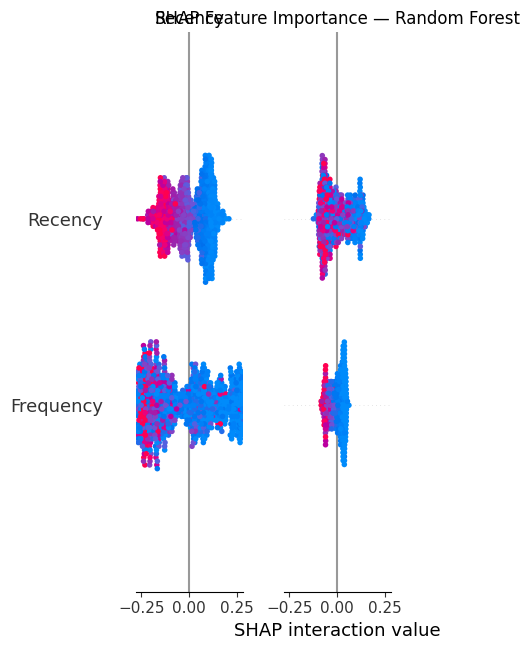

In [14]:
# SHAP analysis on the best tree-based model
best_tree_name = 'XGBoost' if results['XGBoost']['auc'] >= results['Random Forest']['auc'] else 'Random Forest'
best_tree = results[best_tree_name]['model']

explainer = shap.TreeExplainer(best_tree)
shap_values = explainer.shap_values(X_test)

# Summary plot — each dot is one customer, position = impact on prediction
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.title(f'SHAP Feature Importance — {best_tree_name}')
plt.tight_layout()
plt.show()

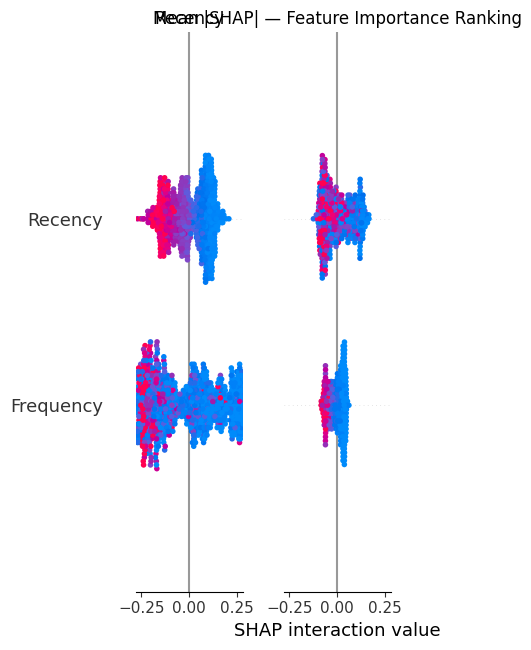

In [15]:
# Bar plot — overall feature importance ranking
shap.summary_plot(shap_values, X_test, feature_names=feature_cols,
                  plot_type='bar', show=False)
plt.title(f'Mean |SHAP| — Feature Importance Ranking')
plt.tight_layout()
plt.show()

## Customer Lifetime Value (CLV) Estimation

**What we're predicting:** How much will a customer spend in the **next 6 months**?

We use features from the training period to predict actual spending in the holdout period. This is a genuine forward-looking prediction — no leakage.

In [16]:
# Ground truth: actual spend in the future period
future_spend = future_purchases.groupby('Customer ID')['TotalAmount'].sum().rename('Future_Spend')

clv_df = cdf.merge(future_spend, on='Customer ID', how='left')
clv_df['Future_Spend'] = clv_df['Future_Spend'].fillna(0)

print(f"Customers with future spend > 0: {(clv_df['Future_Spend'] > 0).sum():,} ({(clv_df['Future_Spend'] > 0).mean()*100:.1f}%)")
print(f"Customers with future spend = 0: {(clv_df['Future_Spend'] == 0).sum():,} ({(clv_df['Future_Spend'] == 0).mean()*100:.1f}%)")
print(f"\nFuture Spend Stats (among those who returned):")
returned = clv_df[clv_df['Future_Spend'] > 0]['Future_Spend']
print(f"  Mean:   £{returned.mean():,.2f}")
print(f"  Median: £{returned.median():,.2f}")
print(f"  Max:    £{returned.max():,.2f}")

Customers with future spend > 0: 2,577 (51.8%)
Customers with future spend = 0: 2,402 (48.2%)

Future Spend Stats (among those who returned):
  Mean:   £1,769.28
  Median: £642.32
  Max:    £168,469.60


In [17]:
# CLV Model — predict future spend from past behavior
clv_features = ['Recency', 'Frequency', 'Monetary', 'Avg_Order_Value', 'Std_Order_Value',
                'Total_Items', 'Unique_Products', 'Avg_Items_Per_Order', 'Total_Orders',
                'Tenure', 'Avg_Days_Between_Orders', 'Cancellation_Count', 'Cancel_Rate', 'Is_UK']

X_clv = clv_df[clv_features]
y_clv = np.log1p(clv_df['Future_Spend'])  # Log transform — heavily right-skewed

X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(
    X_clv, y_clv, test_size=0.2, random_state=42)

clv_model = GradientBoostingRegressor(n_estimators=200, random_state=42,
                                       max_depth=5, learning_rate=0.1)
clv_model.fit(X_train_clv, y_train_clv)

y_pred_clv = clv_model.predict(X_test_clv)

# Metrics in log scale (what the model actually optimizes)
r2_log = r2_score(y_test_clv, y_pred_clv)

# Metrics in original £ scale (what the business cares about)
actual = np.expm1(y_test_clv)
predicted = np.expm1(y_pred_clv)
predicted = np.maximum(predicted, 0)  # Clip negatives
mae = mean_absolute_error(actual, predicted)
r2_original = r2_score(actual, predicted)

print(f"CLV Model (Gradient Boosting Regressor)")
print(f"  R² (log scale):      {r2_log:.4f}")
print(f"  R² (original scale): {r2_original:.4f}")
print(f"  MAE: £{mae:,.2f}")

CLV Model (Gradient Boosting Regressor)
  R² (log scale):      0.3721
  R² (original scale): 0.5054
  MAE: £841.21


In [18]:
# Actual vs Predicted scatter
fig = go.Figure()
fig.add_trace(go.Scatter(x=actual, y=predicted, mode='markers',
                         marker=dict(color='#636EFA', opacity=0.3, size=4),
                         name='Customers'))
max_val = max(actual.max(), predicted.max())
fig.add_trace(go.Scatter(x=[0, max_val], y=[0, max_val],
                         mode='lines', line=dict(dash='dash', color='red'),
                         name='Perfect Prediction'))
fig.update_layout(title=f'Actual vs Predicted CLV (R² = {r2_original:.4f})',
                  xaxis_title='Actual Future Spend (£)',
                  yaxis_title='Predicted Future Spend (£)',
                  template='plotly_white', height=500, width=600)
fig.show()

In [19]:
# CLV Feature Importance
clv_importances = pd.Series(clv_model.feature_importances_, index=clv_features).sort_values(ascending=True)

fig = px.bar(x=clv_importances.values, y=clv_importances.index, orientation='h',
             title='Feature Importance — CLV Model',
             template='plotly_white', color=clv_importances.values,
             color_continuous_scale='Viridis')
fig.update_layout(height=450, width=700, yaxis_title='', xaxis_title='Importance')
fig.show()

## Combining Churn Risk + CLV for Business Recommendations

The real value isn't just predicting churn or CLV in isolation — it's combining them into an **action matrix** that tells the business what to do with each customer.

In [20]:
# Generate churn probability and predicted CLV for ALL customers
best_tree_model = results[best_tree_name]['model']

if best_tree_name == 'Logistic Regression':
    X_all_scaled = scaler.transform(X)
    cdf['Churn_Probability'] = best_tree_model.predict_proba(X_all_scaled)[:, 1]
else:
    cdf['Churn_Probability'] = best_tree_model.predict_proba(X)[:, 1]

cdf['Predicted_CLV'] = np.maximum(np.expm1(clv_model.predict(X_clv)), 0)

print(f"Churn Probability — Mean: {cdf['Churn_Probability'].mean():.3f}, Median: {cdf['Churn_Probability'].median():.3f}")
print(f"Predicted CLV — Mean: £{cdf['Predicted_CLV'].mean():,.2f}, Median: £{cdf['Predicted_CLV'].median():,.2f}")

Churn Probability — Mean: 0.482, Median: 0.440
Predicted CLV — Mean: £491.64, Median: £17.07


In [21]:
# Create action categories based on churn risk + customer value
clv_threshold = cdf['Predicted_CLV'].quantile(0.75)
churn_threshold = 0.5

def recommend_action(row):
    high_clv = row['Predicted_CLV'] > clv_threshold
    high_churn = row['Churn_Probability'] > churn_threshold

    if high_clv and high_churn:
        return 'Priority Retention'     # High value + likely to leave = SAVE THEM
    elif high_clv and not high_churn:
        return 'Protect & Reward'       # High value + staying = keep them happy
    elif not high_clv and high_churn:
        return 'Low-Cost Re-engage'     # Low value + leaving = minimal investment
    else:
        return 'Nurture & Grow'         # Low value + staying = upsell opportunity

cdf['Action'] = cdf.apply(recommend_action, axis=1)

print(f"CLV threshold (75th percentile): £{clv_threshold:,.2f}")
print(f"Churn threshold: {churn_threshold}\n")

print("Business Action Distribution:")
action_counts = cdf['Action'].value_counts()
for action, count in action_counts.items():
    subset = cdf[cdf['Action'] == action]
    avg_clv = subset['Predicted_CLV'].mean()
    avg_churn = subset['Churn_Probability'].mean()
    total_clv = subset['Predicted_CLV'].sum()
    print(f"  {action:25s} — {count:,} customers | Avg CLV: £{avg_clv:,.0f} | Avg Churn: {avg_churn:.1%} | Total Value: £{total_clv:,.0f}")

CLV threshold (75th percentile): £215.00
Churn threshold: 0.5

Business Action Distribution:
  Low-Cost Re-engage        — 2,384 customers | Avg CLV: £8 | Avg Churn: 83.5% | Total Value: £20,062
  Nurture & Grow            — 1,350 customers | Avg CLV: £63 | Avg Churn: 22.6% | Total Value: £84,581
  Protect & Reward          — 1,219 customers | Avg CLV: £1,911 | Avg Churn: 6.9% | Total Value: £2,329,168
  Priority Retention        — 26 customers | Avg CLV: £540 | Avg Churn: 69.0% | Total Value: £14,045


In [22]:
# Visualize the action matrix
fig = px.scatter(cdf, x='Churn_Probability', y='Predicted_CLV',
                 color='Action', opacity=0.5,
                 title='Customer Action Matrix — Churn Risk vs Lifetime Value',
                 color_discrete_sequence=px.colors.qualitative.Set1,
                 log_y=True)
fig.add_hline(y=clv_threshold, line_dash='dash',
              line_color='gray', annotation_text='High CLV Threshold')
fig.add_vline(x=churn_threshold, line_dash='dash',
              line_color='gray', annotation_text='Churn Threshold')
fig.update_layout(template='plotly_white', height=550, width=800,
                  xaxis_title='Churn Probability', yaxis_title='Predicted CLV (£, log scale)')
fig.show()

In [23]:
# Priority Retention — the customers who need immediate attention
priority = cdf[cdf['Action'] == 'Priority Retention'].sort_values('Predicted_CLV', ascending=False)

print(f"Priority Retention Customers: {len(priority):,}")
print(f"Total at-risk revenue: £{priority['Predicted_CLV'].sum():,.0f}")
print(f"\nTop 10 highest-value at-risk customers:")
print(priority[['Customer ID', 'Predicted_CLV', 'Churn_Probability',
                'Recency', 'Frequency', 'Monetary', 'Cancel_Rate']].head(10).to_string(index=False))

Priority Retention Customers: 26
Total at-risk revenue: £14,045

Top 10 highest-value at-risk customers:
 Customer ID  Predicted_CLV  Churn_Probability  Recency  Frequency  Monetary  Cancel_Rate
       12590    2485.561485              0.840       31          2   9864.26     1.500000
       17924    1257.188870              0.590      122          3    797.40     1.000000
       15235    1028.679921              0.665       38         16   2772.76     0.000000
       16883     919.687443              0.665        7         19   2246.06     0.052632
       13093     860.858074              0.625       96         55  54144.25     0.600000
       15381     630.801812              0.675       34          5   1890.57     0.200000
       12868     498.226062              0.750        6          8   2043.76     0.000000
       14465     457.328439              0.600       67         11   3925.85     0.000000
       14616     457.135708              0.725       63          5    527.78     0.00

### Statistical Validation

In [24]:
# t-test: Is the monetary value of churned vs active customers significantly different?
churned_monetary = cdf[cdf['Churned'] == 1]['Monetary']
active_monetary = cdf[cdf['Churned'] == 0]['Monetary']

stat, p_value = stats.ttest_ind(active_monetary, churned_monetary, equal_var=False)
pooled_std = np.sqrt((active_monetary.std()**2 + churned_monetary.std()**2) / 2)
cohens_d = (active_monetary.mean() - churned_monetary.mean()) / pooled_std
effect = 'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small'

print(f"{'='*55}")
print(f"Welch's t-test: Active vs Churned Customers")
print(f"{'='*55}")
print(f"Active:  mean=£{active_monetary.mean():,.2f}, std=£{active_monetary.std():,.2f}, n={len(active_monetary)}")
print(f"Churned: mean=£{churned_monetary.mean():,.2f}, std=£{churned_monetary.std():,.2f}, n={len(churned_monetary)}")
print(f"\nt-statistic: {stat:.4f}")
print(f"p-value: {p_value:.2e}")
print(f"Cohen's d: {cohens_d:.4f} ({effect} effect)")
print(f"\nInterpretation: {'Active customers spend significantly more' if p_value < 0.05 and cohens_d > 0 else 'No significant difference'}")

Welch's t-test: Active vs Churned Customers
Active:  mean=£3,782.17, std=£14,640.25, n=2577
Churned: mean=£972.73, std=£3,218.70, n=2402

t-statistic: 9.4984
p-value: 4.36e-21
Cohen's d: 0.2651 (Small effect)

Interpretation: Active customers spend significantly more


In [25]:
# Chi-square: Is cancellation behavior associated with churn?
cdf['Has_Cancelled'] = (cdf['Cancellation_Count'] > 0).astype(int)

contingency = pd.crosstab(cdf['Churned'], cdf['Has_Cancelled'], margins=True)
contingency.columns = ['Never Cancelled', 'Has Cancelled', 'Total']
contingency.index = ['Active', 'Churned', 'Total']
print("Cancellation vs Churn:")
print(contingency.to_string())

chi2, p_val, dof, expected = stats.chi2_contingency(
    pd.crosstab(cdf['Churned'], cdf['Has_Cancelled']))

n = len(cdf)
cramers_v = np.sqrt(chi2 / n)  # 2x2 table so min_dim = 1

print(f"\nChi² = {chi2:.4f}, p = {p_val:.2e}, Cramér's V = {cramers_v:.4f}")
print(f"Result: {'Cancellation behavior is associated with churn' if p_val < 0.05 else 'No significant association'}")

# Show churn rates
churn_no_cancel = cdf[cdf['Has_Cancelled'] == 0]['Churned'].mean()
churn_with_cancel = cdf[cdf['Has_Cancelled'] == 1]['Churned'].mean()
print(f"\nChurn rate — never cancelled: {churn_no_cancel*100:.1f}%")
print(f"Churn rate — has cancelled:   {churn_with_cancel*100:.1f}%")

Cancellation vs Churn:
         Never Cancelled  Has Cancelled  Total
Active              1190           1387   2577
Churned             1699            703   2402
Total               2889           2090   4979

Chi² = 306.7550, p = 1.11e-68, Cramér's V = 0.2482
Result: Cancellation behavior is associated with churn

Churn rate — never cancelled: 58.8%
Churn rate — has cancelled:   33.6%


### Phase 3 Key Takeaways

**Fill in the numbers after running:**

1. **Temporal Split:** Training on data before [split date], predicting churn based on whether customers returned in the final 6 months. X% of customers churned.

2. **Best Churn Model:** [Model name] achieved AUC of X.XX with X% recall on churners — meaning we catch X out of every 100 customers who actually leave.

3. **Top Churn Drivers (SHAP):** [List top 3 features]. Recency is expected to be dominant, but other features like [X] and [X] reveal non-obvious patterns.

4. **CLV Model:** R² = X.XX (log scale), MAE = £X — predicting future 6-month spend from past behavior.

5. **Business Action Matrix:**
   - **Priority Retention** — X customers with £X total at-risk revenue. These need immediate personal outreach.
   - **Protect & Reward** — X customers. Keep them happy with VIP treatment.
   - **Nurture & Grow** — X customers. Upsell and cross-sell opportunities.
   - **Low-Cost Re-engage** — X customers. Automated win-back emails only.

6. **Data Leakage Lesson:** Initial approach using Recency-based churn definition with Recency as a feature gave perfect AUC = 1.0 (meaningless). Temporal split produced honest, realistic, and defensible results.